# Flagship Cluster Catalogue Analysis

This notebook compares Euclid Flagship simulation cluster catalogue summary statistics with capish predictions.

In [147]:
import pyccl, sys
print("pyccl version:", pyccl.__version__)
print("pyccl path   :", pyccl.__file__)
print("python exe   :", sys.executable)

pyccl version: 3.2.1
pyccl path   : /sps/euclid/Users/cmurray/miniconda3/envs/capish/lib/python3.11/site-packages/pyccl/__init__.py
python exe   : /sps/euclid/Users/cmurray/miniconda3/envs/capish/bin/python


In [148]:
import torch

In [149]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root))

from modules.simulation import UniverseSimulator
import configparser

## 1. Load Flagship Summary Statistics

In [150]:
# Load Flagship data
flagship_path = project_root / 'euclid_flagship_simulations' / 'flagship_cluster_catalogue_summary_statstics_DES_MoR_Mwl_scatter_Gamma0.7.npy'
flagship_data = np.load(flagship_path, allow_pickle=True).item()

print("Flagship data keys:", flagship_data.keys())
print("\nData shapes:")
for key, value in flagship_data.items():
    print(f"  {key}: {value.shape}")

Flagship data keys: dict_keys(['count_with_m200b_def', 'mean_log10m200b', 'count_with_m200c_def', 'mean_log10m200c'])

Data shapes:
  count_with_m200b_def: (5, 4)
  mean_log10m200b: (5, 4)
  count_with_m200c_def: (5, 4)
  mean_log10m200c: (5, 4)


In [151]:
# Extract data for easier access
flagship_counts_m200b = flagship_data['count_with_m200b_def']
flagship_mean_log10m200b = flagship_data['mean_log10m200b']
flagship_counts_m200c = flagship_data['count_with_m200c_def']
flagship_mean_log10m200c = flagship_data['mean_log10m200c']

print(f"Flagship data structure:")
print(f"  Counts shape: {flagship_counts_m200b.shape}")
print(f"  Mean masses shape: {flagship_mean_log10m200b.shape}")

Flagship data structure:
  Counts shape: (5, 4)
  Mean masses shape: (5, 4)


## 2. Load Configuration and Initialize Simulator

Load the Flagship configuration file directly.

In [152]:
# Load configuration from file
config_path = project_root / 'config' / 'capish_flagship.ini'

print(f"Loading configuration from: {config_path}")
print(f"Configuration file exists: {config_path.exists()}")

# Read config to display key settings
config = configparser.ConfigParser()
config.read(config_path)

# Display some key parameters
print("\nKey Configuration Parameters:")
print("="*60)
print("Cosmology:")
print(f"  Omega_m = {config['parameters']['Omega_m']}")
print(f"  sigma8 = {config['parameters']['sigma8']}")
print(f"  h = {config['parameters']['h']}")

print("\nMass-Observable Relation:")
print(f"  M_min = {config['parameters']['M_min']}")
print(f"  alpha_lambda = {config['parameters']['alpha_lambda']}")
print(f"  beta_lambda = {config['parameters']['beta_lambda']}")
print(f"  sigma_lambda = {config['parameters']['sigma_lambda']}")

print("\nSurvey Settings:")
print(f"  Sky area = {config['halo_catalogue']['sky_area']} sr")
area_sr = float(config['halo_catalogue']['sky_area'])
area_deg2 = area_sr * (180/np.pi)**2
print(f"           = {area_deg2:.1f} deg²")

print("\nBinning:")
print(f"  Richness bins: {config['summary_statistics']['richness_edges']}")
print(f"  Redshift bins: {config['summary_statistics']['redshift_edges']}")

# Extract binning for later use
richness_edges = np.array([float(x) for x in config['summary_statistics']['richness_edges'].split(',')])
redshift_edges = np.array([float(x) for x in config['summary_statistics']['redshift_edges'].split(',')])

n_richness_bins = len(richness_edges) - 1
n_redshift_bins = len(redshift_edges) - 1

print(f"\n  Number of richness bins: {n_richness_bins}")
print(f"  Number of redshift bins: {n_redshift_bins}")
print(f"  Total bins: {n_richness_bins * n_redshift_bins}")
print("="*60)

Loading configuration from: /pbs/home/c/cmurray/cluster_likelihood/config/capish_flagship.ini
Configuration file exists: True

Key Configuration Parameters:
Cosmology:
  Omega_m = 0.319
  sigma8 = 0.813
  h = 0.67

Mass-Observable Relation:
  M_min = 134896288259.1656
  alpha_lambda = -9.348
  beta_lambda = 0.75
  sigma_lambda = 0.3

Survey Settings:
  Sky area = 1.5708 sr
           = 5156.6 deg²

Binning:
  Richness bins: 20, 30, 50, 80, 130, 200
  Redshift bins: 0.2, 0.3, 0.4, 0.8, 1.0

  Number of richness bins: 5
  Number of redshift bins: 4
  Total bins: 20


In [153]:
# Initialize simulator with the configuration file
simulator = UniverseSimulator(
    default_config_path=str(config_path),
    variable_params_names=['Omega_m', 'sigma8', 'alpha_lambda', 'beta_lambda', 'sigma_lambda']
)

print("Simulator initialized successfully")
print(f"Mass function: {simulator.halo_catalogue_class.hmf}")
print(f"Mass definition: {simulator.halo_catalogue_class.mass_definition}")

Simulator initialized successfully
Mass function: <pyccl.halos.hmfunc.tinker10.MassFuncTinker10>
	mass_def = MassDef(Delta=200, rho_type=matter)
Mass definition: MassDef(Delta=200, rho_type=matter)


In [154]:
# Set fiducial parameter values for simulation (from config file)
fiducial_values = [
    float(config['parameters']['Omega_m']),
    float(config['parameters']['sigma8']),
    float(config['parameters']['alpha_lambda']),
    float(config['parameters']['beta_lambda']),
    float(config['parameters']['sigma_lambda'])
]

print("Fiducial parameter values:")
print(f"  Omega_m = {fiducial_values[0]}")
print(f"  sigma8 = {fiducial_values[1]}")
print(f"  alpha_lambda = {fiducial_values[2]}")
print(f"  beta_lambda = {fiducial_values[3]}")
print(f"  sigma_lambda = {fiducial_values[4]}")

Fiducial parameter values:
  Omega_m = 0.319
  sigma8 = 0.813
  alpha_lambda = -9.348
  beta_lambda = 0.75
  sigma_lambda = 0.3


In [155]:
# Run simulation
print("Running capish simulation...")
print("="*70)
summary_stats = simulator.run_simulation(fiducial_values)
print("="*70)

print(f"\nSummary stats type: {type(summary_stats)}")
if isinstance(summary_stats, tuple):
    print(f"Tuple length: {len(summary_stats)}")
    for i, item in enumerate(summary_stats):
        print(f"  Item {i}: type={type(item)}, shape={getattr(item, 'shape', 'N/A')}")

Running capish simulation...

Summary stats type: <class 'tuple'>
Tuple length: 2
  Item 0: type=<class 'numpy.ndarray'>, shape=(5, 4)
  Item 1: type=<class 'numpy.ndarray'>, shape=(5, 4)


In [156]:
def summary_statistic_to_sensible_format(summary_statistic, n_richness, n_z):
    """
    Format Capish results to match Flagship structure.
    Capish returns tuple (counts, masses) with shape (n_richness, n_z).
    Flagship has shape (n_richness, n_z).
    """
    if isinstance(summary_statistic, tuple) and len(summary_statistic) == 2:
        # New format: tuple of (counts, masses)
        count_stat, mass_stat = summary_statistic
        capish_counts = np.array(count_stat)
        capish_masses = np.array(mass_stat)
        
        # Capish returns (n_richness, n_z), which matches Flagship format
        print(f"Capish raw counts shape: {capish_counts.shape}")
        print(f"Capish raw masses shape: {capish_masses.shape}")
        
    else:
        # Old format: flat array
        n_total_bins = n_richness * n_z
        capish_counts = summary_statistic[:n_total_bins].reshape(n_richness, n_z)
        capish_masses = summary_statistic[n_total_bins:].reshape(n_richness, n_z)
    
    return capish_counts, capish_masses

# Format the Capish results
capish_counts, capish_mean_masses = summary_statistic_to_sensible_format(
    summary_stats, n_richness_bins, n_redshift_bins
)

print(f"\nCapish counts shape: {capish_counts.shape}")
print(f"Capish mean masses shape: {capish_mean_masses.shape}")
print(f"\nCapish counts:\n{capish_counts}")
print(f"\nCapish masses:\n{capish_mean_masses}")

Capish raw counts shape: (5, 4)
Capish raw masses shape: (5, 4)

Capish counts shape: (5, 4)
Capish mean masses shape: (5, 4)

Capish counts:
[[3.9010e+03 6.3170e+03 3.6575e+04 1.7686e+04]
 [1.8830e+03 2.7630e+03 1.4058e+04 5.4260e+03]
 [5.0300e+02 6.4100e+02 2.5400e+03 7.2300e+02]
 [1.1600e+02 1.3700e+02 4.1000e+02 7.5000e+01]
 [9.0000e+00 1.5000e+01 3.4000e+01 3.0000e+00]]

Capish masses:
[[14.13687174 14.11782056 14.08750486 14.03502768]
 [14.39051979 14.37912015 14.34213604 14.27462124]
 [14.66563085 14.64621439 14.60348553 14.53857779]
 [14.88429343 14.87585284 14.85574486 14.76769131]
 [15.23240695 15.01595065 15.05748113 15.12850022]]


## 4. Compare Capish vs Flagship

### 1D Comparison Plots

In [157]:
# Note: Using M200b for comparison since config has mass_def_overdensity_type = matter
flagship_counts = flagship_counts_m200b
flagship_mean_masses = flagship_mean_log10m200b

# Calculate richness bin centers
richness_centers = (richness_edges[:-1] + richness_edges[1:]) / 2

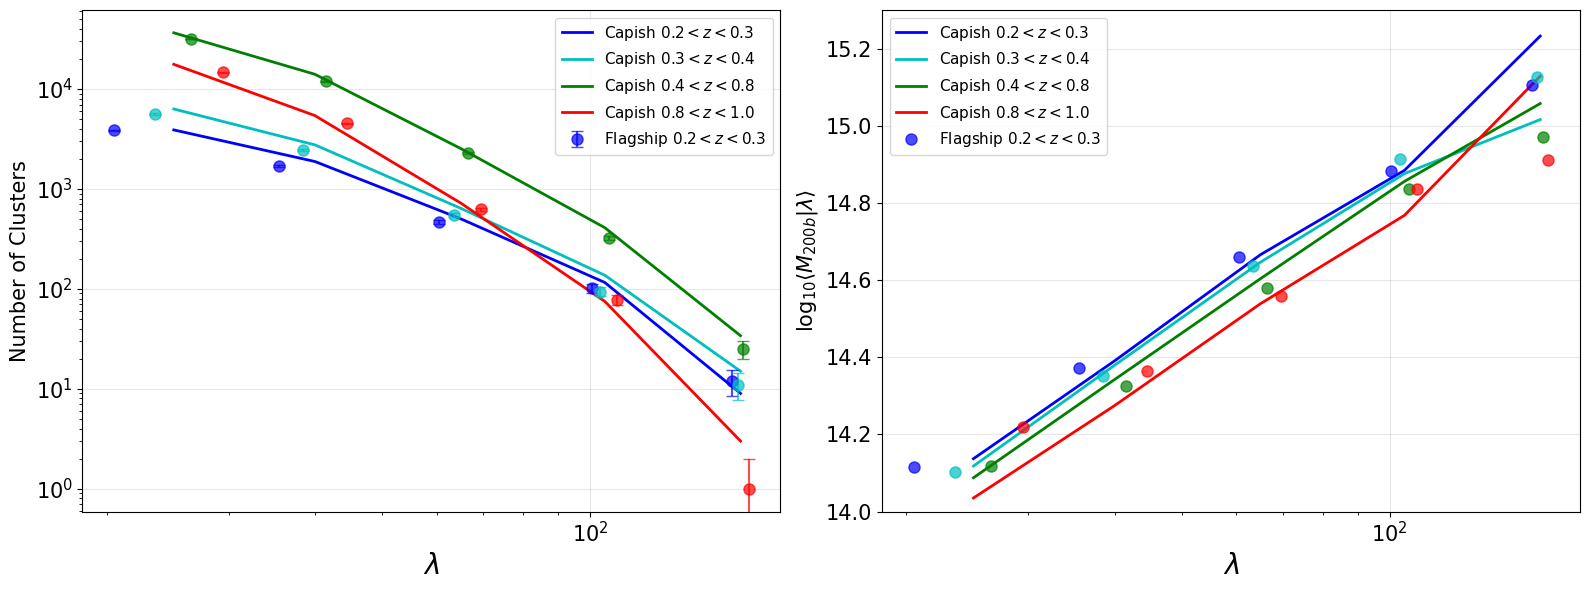


CAPISH vs FLAGSHIP COMPARISON

z-bin 1 (0.2-0.3):
  Flagship counts: [3861 1708  470  101   12]
  Capish counts:   [3901 1883  503  116    9]
  Flagship masses: [14.117, 14.372, 14.659, 14.883, 15.106]
  Capish masses:   [14.137, 14.391, 14.666, 14.884, 15.232]

z-bin 2 (0.3-0.4):
  Flagship counts: [5627 2448  549   94   11]
  Capish counts:   [6317 2763  641  137   15]
  Flagship masses: [14.104, 14.35 , 14.635, 14.914, 15.127]
  Capish masses:   [14.118, 14.379, 14.646, 14.876, 15.016]

z-bin 3 (0.4-0.8):
  Flagship counts: [31809 11948  2292   324    25]
  Capish counts:   [36575 14058  2540   410    34]
  Flagship masses: [14.117, 14.324, 14.579, 14.835, 14.97 ]
  Capish masses:   [14.088, 14.342, 14.603, 14.856, 15.057]

z-bin 4 (0.8-1.0):
  Flagship counts: [14704  4532   625    78     1]
  Capish counts:   [17686  5426   723    75     3]
  Flagship masses: [14.219, 14.364, 14.56 , 14.836, 14.912]
  Capish masses:   [14.035, 14.275, 14.539, 14.768, 15.129]


In [158]:
# Plot: 1D comparison - counts and mean masses vs richness (similar to DES example)
fig = plt.figure(figsize=(16, 6))

# Colors and labels for redshift bins
colors = ['b-', 'c-', 'g-', 'r-']
z_labels = [f'$ {redshift_edges[i]:.1f} < z < {redshift_edges[i+1]:.1f} $' 
            for i in range(n_redshift_bins)]

# Subplot 1: Number of clusters
plt.subplot(121)

# Plot Capish predictions (solid lines) - transposed to iterate over redshift bins
for i in range(n_redshift_bins):
    plt.plot(richness_centers, capish_counts[:, i], colors[i], linewidth=2, 
             label=f'Capish {z_labels[i]}')

# Plot Flagship observations as points with Poisson errors
for i in range(n_redshift_bins):
    count_errors = np.sqrt(np.maximum(flagship_counts[:, i], 1))
    plt.errorbar(richness_centers + (i-1.5)*3, flagship_counts[:, i], yerr=count_errors,
                fmt='o', color=colors[i][0], markersize=8, capsize=4, alpha=0.7, 
                label=f'Flagship {z_labels[i]}' if i == 0 else None)

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\lambda$', fontsize=20)
plt.ylabel('Number of Clusters', fontsize=15)
handles, labels = plt.gca().get_legend_handles_labels()
# Only show one Flagship entry in legend
new_labels = []
new_handles = []
for h, l in zip(handles, labels):
    if l not in new_labels:
        new_labels.append(l)
        new_handles.append(h)
plt.legend(new_handles, new_labels, loc='upper right', fontsize=11)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True, alpha=0.3)

# Subplot 2: Mean M200b
plt.subplot(122)

# Plot Capish predictions (solid lines)
for i in range(n_redshift_bins):
    plt.plot(richness_centers, capish_mean_masses[:, i], colors[i], linewidth=2, 
             label=f'Capish {z_labels[i]}')

# Plot Flagship observations as points (no error bars available for mean masses)
for i in range(n_redshift_bins):
    plt.plot(richness_centers + (i-1.5)*3, flagship_mean_masses[:, i], 
            'o', color=colors[i][0], markersize=8, alpha=0.7, 
            label=f'Flagship {z_labels[i]}' if i == 0 else None)

plt.xscale('log')
plt.ylim(14.0, 15.3)
plt.xlabel(r'$\lambda$', fontsize=20)
plt.ylabel(r'log$_{10} \langle M_{200b} | \lambda \rangle$', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True, alpha=0.3)

handles, labels = plt.gca().get_legend_handles_labels()
new_labels = []
new_handles = []
for h, l in zip(handles, labels):
    if l not in new_labels:
        new_labels.append(l)
        new_handles.append(h)
plt.legend(new_handles, new_labels, loc='upper left', fontsize=11)

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*60)
print("CAPISH vs FLAGSHIP COMPARISON")
print("="*60)
for i in range(n_redshift_bins):
    print(f"\nz-bin {i+1} ({redshift_edges[i]:.1f}-{redshift_edges[i+1]:.1f}):")
    print(f"  Flagship counts: {flagship_counts[:, i].astype(int)}")
    print(f"  Capish counts:   {capish_counts[:, i].astype(int)}")
    print(f"  Flagship masses: {np.array2string(flagship_mean_masses[:, i], precision=3, separator=', ')}")
    print(f"  Capish masses:   {np.array2string(capish_mean_masses[:, i], precision=3, separator=', ')}")

/scratch/users/c/cmurray/ipykernel_3957448/1558329659.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


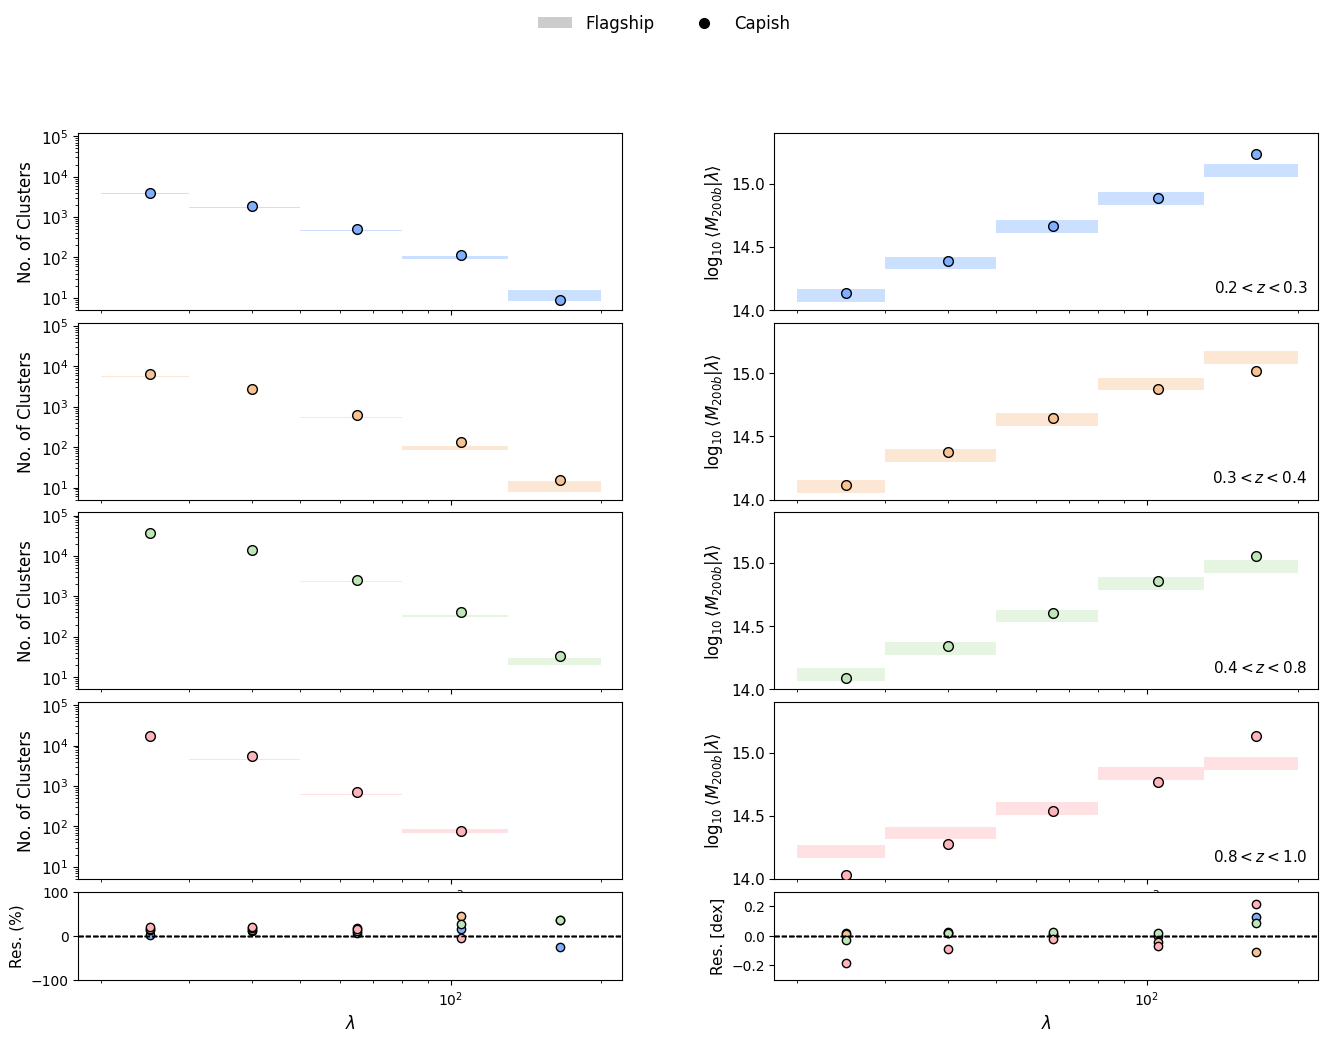

In [159]:
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Style choices
colors = ['#7fb0ff', '#f7c394', '#bfe6b8', '#ffb3ba']   # pastel colors for 4 redshift bins
point_edge = 'k'
z_labels = [f'${redshift_edges[i]:.1f} < z < {redshift_edges[i+1]:.1f}$' 
            for i in range(n_redshift_bins)]

fig = plt.figure(figsize=(16, 11))
gs = gridspec.GridSpec(5, 2, height_ratios=[1,1,1,1,0.5], hspace=0.08, wspace=0.28)

# --- top 4 rows: data bands (shaded) and Capish points ---
for i in range(n_redshift_bins):
    ax_counts = fig.add_subplot(gs[i, 0])
    ax_mass   = fig.add_subplot(gs[i, 1])
    
    # ---- COUNTS panel: shaded band = flagship_counts +/- sqrt(flagship_counts) (Poisson-like) ----
    count_errs = np.sqrt(np.maximum(flagship_counts[:, i], 1.0))
    for j in range(n_richness_bins):
        lam_l = richness_edges[j]
        lam_r = richness_edges[j+1]
        y_low  = max(1e-1, flagship_counts[j, i] - count_errs[j])
        y_high = flagship_counts[j, i] + count_errs[j]
        ax_counts.fill_between([lam_l, lam_r], [y_low, y_low], [y_high, y_high],
                               color=colors[i], alpha=0.4, edgecolor='none')

    ax_counts.plot(richness_centers, capish_counts[:, i], 'o',
                   markerfacecolor=colors[i], markeredgecolor=point_edge, markersize=7, zorder=10)

    ax_counts.set_xscale('log')
    ax_counts.set_yscale('log')
    ax_counts.set_xlim(18, 220)
    ax_counts.set_ylim(5e0, 1.2e5)
    ax_counts.set_ylabel('No. of Clusters', fontsize=12)
    ax_counts.tick_params(labelsize=11)
    if i < n_redshift_bins-1:
        ax_counts.set_xticklabels([])
    else:
        ax_counts.set_xlabel(r'$\lambda$', fontsize=13)

    # ---- MASS panel: shaded band ----
    for j in range(n_richness_bins):
        lam_l = richness_edges[j]
        lam_r = richness_edges[j+1]
        y_low  = flagship_mean_masses[j, i] - 0.05
        y_high = flagship_mean_masses[j, i] + 0.05
        ax_mass.fill_between([lam_l, lam_r], [y_low, y_low], [y_high, y_high],
                             color=colors[i], alpha=0.4, edgecolor='none')

    ax_mass.plot(richness_centers, capish_mean_masses[:, i], 'o',
                 markerfacecolor=colors[i], markeredgecolor=point_edge, markersize=7, zorder=10)

    ax_mass.set_xscale('log')
    ax_mass.set_xlim(18, 220)
    ax_mass.set_ylim(14.0, 15.4)
    ax_mass.set_ylabel(r'$\log_{10}\langle M_{200b}|\lambda\rangle$', fontsize=12)
    ax_mass.tick_params(labelsize=11)
    if i < n_redshift_bins-1:
        ax_mass.set_xticklabels([])
    else:
        ax_mass.set_xlabel(r'$\lambda$', fontsize=13)

    ax_mass.text(0.98, 0.08, z_labels[i], transform=ax_mass.transAxes,
                 ha='right', va='bottom', fontsize=11,
                 bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=6))

# --- bottom row: residuals ---
ax_res_counts = fig.add_subplot(gs[n_redshift_bins, 0])
ax_res_mass   = fig.add_subplot(gs[n_redshift_bins, 1])

for i in range(n_redshift_bins):
    with np.errstate(divide='ignore', invalid='ignore'):
        res_counts = (capish_counts[:, i] - flagship_counts[:, i]) / flagship_counts[:, i] * 100.0
        res_counts = np.where(flagship_counts[:, i] > 0, res_counts, np.nan)
        res_masses = capish_mean_masses[:, i] - flagship_mean_masses[:, i]

    ax_res_counts.plot(richness_centers, res_counts, 'o', color=colors[i], 
                      markeredgecolor=point_edge, markersize=6)
    ax_res_counts.axhline(0.0, linestyle='--', color='k', linewidth=1)

    ax_res_mass.plot(richness_centers, res_masses, 'o', color=colors[i], 
                    markeredgecolor=point_edge, markersize=6)
    ax_res_mass.axhline(0.0, linestyle='--', color='k', linewidth=1)

ax_res_counts.set_xscale('log')
ax_res_counts.set_xlim(18, 220)
ax_res_counts.set_xlabel(r'$\lambda$', fontsize=12)
ax_res_counts.set_ylabel('Res. (%)', fontsize=11)
ax_res_counts.tick_params(labelsize=10)
ax_res_counts.set_ylim(-100, 100)

ax_res_mass.set_xscale('log')
ax_res_mass.set_xlim(18, 220)
ax_res_mass.set_xlabel(r'$\lambda$', fontsize=12)
ax_res_mass.set_ylabel('Res. [dex]', fontsize=11)
ax_res_mass.tick_params(labelsize=10)
ax_res_mass.set_ylim(-0.3, 0.3)

legend_handles = [
    Patch(facecolor='gray', alpha=0.4, label='Flagship'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='k',
           markeredgecolor=point_edge, markersize=7, label='Capish')
]
fig.legend(handles=legend_handles, loc='upper center', ncol=2, frameon=False, fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 5. Parameter Inference

Use simulation-based inference (SBI) to infer cosmological and mass-observable parameters from Flagship data.

In [160]:
# Check if sbi is available, install if needed
try:
    import sbi
    print(f"sbi version: {sbi.__version__}")
except ImportError:
    print("sbi not found. Install with: pip install sbi")
    print("For now, we'll show the inference workflow structure.")

sbi version: 0.25.0


In [161]:
# Define parameter priors for inference
# We'll infer a subset of parameters, keeping others fixed

import torch
from sbi.utils import BoxUniform

# Define priors (matching run_sbi.py)
prior_dict = {
    'Omega_m': [0.1, 0.6],           # Wide cosmological range
    'sigma8': [0.5, 1.0],            # Wide cosmological range
    'alpha_lambda': [-10.0, -8.5],   # MR relation normalization
    'beta_lambda': [0.6, 0.9],       # MR relation slope
    'sigma_lambda': [0.1, 0.5]       # Intrinsic scatter
}

# Create prior distribution
prior_min = torch.tensor([bounds[0] for bounds in prior_dict.values()])
prior_max = torch.tensor([bounds[1] for bounds in prior_dict.values()])
prior = BoxUniform(low=prior_min, high=prior_max)

print("Prior ranges:")
for param, bounds in prior_dict.items():
    print(f"  {param}: [{bounds[0]}, {bounds[1]}]")

print(f"\nNumber of parameters to infer: {len(prior_dict)}")

Prior ranges:
  Omega_m: [0.1, 0.6]
  sigma8: [0.5, 1.0]
  alpha_lambda: [-10.0, -8.5]
  beta_lambda: [0.6, 0.9]
  sigma_lambda: [0.1, 0.5]

Number of parameters to infer: 5


In [162]:
# Create simulator wrapper for SBI
# SBI expects: simulator(parameters) -> observations

SUMMARY_VECTOR_SIZE = 2 * n_richness_bins * n_redshift_bins

def sbi_simulator(theta_tensor):
    """
    Wrapper for UniverseSimulator compatible with SBI.

    Handles batched and single inputs and returns flattened summary statistics.

    Args:
        theta_tensor (torch.Tensor): shape (..., 5) with
            [Omega_m, sigma8, alpha_lambda, beta_lambda, sigma_lambda]
    Returns:
        torch.Tensor: shape (..., SUMMARY_VECTOR_SIZE)
    """
    if theta_tensor.ndim == 1:
        theta_batch = theta_tensor.unsqueeze(0)
        squeeze_output = True
    else:
        theta_batch = theta_tensor
        squeeze_output = False

    outputs = []
    for theta in theta_batch:
        theta_np = theta.detach().cpu().numpy()
        # All 5 parameters are now variable
        full_params = [
            float(theta_np[0]),  # Omega_m
            float(theta_np[1]),  # sigma8
            float(theta_np[2]),  # alpha_lambda
            float(theta_np[3]),  # beta_lambda
            float(theta_np[4])   # sigma_lambda
        ]
        summary_stats = simulator.run_simulation(full_params)
        counts, masses = summary_statistic_to_sensible_format(
            summary_stats, n_richness_bins, n_redshift_bins
        )
        data_vector = np.concatenate([counts.flatten(), masses.flatten()])
        outputs.append(torch.tensor(data_vector, dtype=torch.float32))

    outputs_tensor = torch.stack(outputs)
    return outputs_tensor[0] if squeeze_output else outputs_tensor

print("SBI simulator wrapper created")
print(f"Summary vector length: {SUMMARY_VECTOR_SIZE}")
print(f"Number of variable parameters: 5")

SBI simulator wrapper created
Summary vector length: 40
Number of variable parameters: 5


In [163]:
# Prepare observed data (Flagship) for inference
observed_counts = flagship_counts.flatten()
observed_masses = flagship_mean_masses.flatten()
observed_data = np.concatenate([observed_counts, observed_masses])
observed_data_tensor = torch.tensor(observed_data, dtype=torch.float32)

print(f"Observed data vector shape: {observed_data.shape}")
print(f"Number of summary statistics: {len(observed_data)}")
print(f"  - Count bins: {len(observed_counts)}")
print(f"  - Mass bins: {len(observed_masses)}")

Observed data vector shape: (40,)
Number of summary statistics: 40
  - Count bins: 20
  - Mass bins: 20


In [164]:
# Train neural posterior estimator (SNPE)
import time
import pickle
from pathlib import Path
from sbi.inference import SNPE

posterior_cache_path = project_root / 'notebooks' / 'calum' / 'flagship_posterior.pkl'
force_retrain = False  # set to True to force a fresh training run
num_simulations = 400   # increase for tighter posteriors (runtime scales linearly)

if posterior_cache_path.exists() and not force_retrain:
    with open(posterior_cache_path, 'rb') as handle:
        posterior = pickle.load(handle)
    print(f'Loaded cached posterior from {posterior_cache_path}')
else:
    print(f'Running {num_simulations} simulations to train the posterior. This may take a while...')
    torch.manual_seed(42)
    np.random.seed(42)

    theta_bank = prior.sample((num_simulations,))
    x_bank = torch.zeros(num_simulations, SUMMARY_VECTOR_SIZE, dtype=torch.float32)

    start = time.time()
    for idx, theta in enumerate(theta_bank):
        x_bank[idx] = sbi_simulator(theta)
        if (idx + 1) % 50 == 0 or idx + 1 == num_simulations:
            elapsed = time.time() - start
            print(f'  {idx + 1:4d}/{num_simulations} simulations '
                  f'(avg {elapsed / (idx + 1):.2f} s each)')
    total = time.time() - start
    print(f'Simulations complete in {total / 60:.2f} min. Training neural posterior...')

    inference = SNPE(prior=prior)
    density_estimator = inference.append_simulations(theta_bank, x_bank, proposal=prior).train()
    posterior = inference.build_posterior(density_estimator)

    with open(posterior_cache_path, 'wb') as handle:
        pickle.dump(posterior, handle)
    print(f'Saved posterior to {posterior_cache_path}')

print('Posterior ready. Use `posterior.sample()` with an observation to draw samples.')


Loaded cached posterior from /pbs/home/c/cmurray/cluster_likelihood/notebooks/calum/flagship_posterior.pkl
Posterior ready. Use `posterior.sample()` with an observation to draw samples.


### Posterior Sampling and Visualisation

In [165]:
# Sample the posterior for the Flagship data vector and a Capish mock catalogue
try:
    import corner
except ImportError as exc:
    raise ImportError('Install corner with `pip install corner` before running this cell.') from exc

param_labels = [r'$\Omega_m$', r'$\sigma_8$', r'$\alpha_\lambda$', r'$\beta_\lambda$', r'$\sigma_\lambda$']
num_posterior_samples = 50000

posterior_samples_flagship = posterior.sample((num_posterior_samples,), x=observed_data_tensor)
posterior_samples_flagship_np = posterior_samples_flagship.cpu().numpy()

fiducial_theta = torch.tensor([
    float(config['parameters']['Omega_m']),
    float(config['parameters']['sigma8']),
    float(config['parameters']['alpha_lambda']),
    float(config['parameters']['beta_lambda']),
    float(config['parameters']['sigma_lambda'])
], dtype=torch.float32)
mock_data_tensor = sbi_simulator(fiducial_theta)
posterior_samples_mock = posterior.sample((num_posterior_samples,), x=mock_data_tensor)
posterior_samples_mock_np = posterior_samples_mock.cpu().numpy()

def summarise(samples, labels, label_name):
    percentiles = np.percentile(samples, [16, 50, 84], axis=0)
    print(f"\n{label_name} credible intervals:")
    for lbl, p16, p50, p84 in zip(labels, percentiles[0], percentiles[1], percentiles[2]):
        print(f"  {lbl}: {p50:.3f} (+{p84 - p50:.3f}/-{p50 - p16:.3f})")

print('Posterior samples ready:')
print(f"  Flagship samples: {posterior_samples_flagship_np.shape}")
print(f"  Mock samples:     {posterior_samples_mock_np.shape}")

summarise(posterior_samples_flagship_np, param_labels, 'Flagship')
summarise(posterior_samples_mock_np, param_labels, 'Capish mock')

51938it [00:00, 104654.64it/s]                           


Capish raw counts shape: (5, 4)
Capish raw masses shape: (5, 4)


51088it [00:00, 122334.26it/s]                           

Posterior samples ready:
  Flagship samples: (50000, 4)
  Mock samples:     (50000, 4)

Flagship credible intervals:
  $\Omega_m$: 0.293 (+0.046/-0.045)
  $\sigma_8$: 0.804 (+0.053/-0.053)
  $\alpha_\lambda$: -9.277 (+0.421/-0.407)
  $\beta_\lambda$: 0.749 (+0.029/-0.030)

Capish mock credible intervals:
  $\Omega_m$: 0.275 (+0.046/-0.042)
  $\sigma_8$: 0.800 (+0.052/-0.052)
  $\alpha_\lambda$: -9.269 (+0.416/-0.409)
  $\beta_\lambda$: 0.749 (+0.030/-0.029)


In [166]:
# # Corner plots for Flagship and Capish mock posteriors
# corner_kwargs = dict(labels=param_labels, show_titles=True, title_fmt='.3f', quantiles=[0.16, 0.5, 0.84], label_kwargs={'fontsize': 12})

# fig_flagship = corner.corner(
#     posterior_samples_flagship_np,
#     truths=fiducial_theta.cpu().numpy(),
#     color='#1f77b4',
#     **corner_kwargs
# )
# fig_flagship.suptitle('Posterior | Flagship summary statistics', fontsize=14)
# fig_flagship.tight_layout()

# fig_mock = corner.corner(
#     posterior_samples_mock_np,
#     truths=fiducial_theta.cpu().numpy(),
#     color='#ff7f0e',
#     **corner_kwargs
# )
# fig_mock.suptitle('Posterior | Capish mock summary statistics', fontsize=14)
# fig_mock.tight_layout()
